In [38]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom modules
from hyperparameter_tuning import get_param_grids, tune_hyperparameters
from model_visualization import plot_model_comparison



In [39]:
# Cell 2: Load and Prepare Data
print("Loading and preparing data...")
# Load data
data = pd.read_csv('augmented_bakery_data.csv')

# Encode Product Type
le_product = LabelEncoder()
data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])

# Encode Storage Conditions
le_storage = LabelEncoder()
data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])

print("\nProduct Type Encoding:")
for i, label in enumerate(le_product.classes_):
    print(f"{label}: {i}")

print("\nStorage Condition Encoding:")
for i, label in enumerate(le_storage.classes_):
    print(f"{label}: {i}")



Loading and preparing data...

Product Type Encoding:
Bread: 0
Cookies: 1

Storage Condition Encoding:
Humid: 0
Open: 1
Wrapped: 2


In [40]:
# Cell 3: Model Evaluation Function
def evaluate_model(X, y, model):
    """Evaluate model using 10-fold cross-validation"""
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_y_true = []
    all_y_pred = []
    
    for train_idx, val_idx in kfold.split(X, y):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Store results
        fold_accuracies.append(np.mean(y_pred == y_val))
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
    
    return {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies),
        'classification_report': classification_report(all_y_true, all_y_pred),
        'confusion_matrix': confusion_matrix(all_y_true, all_y_pred)
    }



In [41]:
# Cell 4: Run Classification Without Product Type
print("\nPreparing features without product type...")
# Get features (gains and phases only)
feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
X_without_product = data[feature_cols]
y_storage = data['Storage_Condition_encoded']

# Scale features
scaler = StandardScaler()
X_without_product_scaled = scaler.fit_transform(X_without_product)

# Get parameter grids
param_grids = get_param_grids()

# Dictionary to store results
results_without_product = {}

# Run classification for each model
for model_name, param_grid in param_grids.items():
    print(f"\nTraining {model_name} without product type...")
    try:
        # Tune hyperparameters
        tuning_results = tune_hyperparameters(X_without_product_scaled, y_storage, 
                                            model_name, param_grid)
        # Evaluate model with best parameters
        eval_results = evaluate_model(X_without_product_scaled, y_storage, 
                                    tuning_results['best_model'])
        
        # Combine results
        results_without_product[model_name] = {
            'best_params': tuning_results['best_params'],
            'best_score': tuning_results['best_score'],
            **eval_results
        }
        print(f"Successfully trained {model_name}")
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")




Preparing features without product type...

Training SVM without product type...
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Successfully trained SVM

Training Random Forest without product type...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Successfully trained Random Forest

Training KNN without product type...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Successfully trained KNN

Training Neural Network without product type...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Successfully trained Neural Network

Training Logistic Regression without product type...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Successfully trained Logistic Regression


In [42]:
# Cell 5: Run Classification With Product Type
print("\nPreparing features with product type...")
# Add product type feature
X_with_product = np.column_stack([
    X_without_product_scaled,
    data['Product_Type_encoded'].values.reshape(-1, 1)
])

# Dictionary to store results
results_with_product = {}

# Run classification for each model
for model_name, param_grid in param_grids.items():
    print(f"\nTraining {model_name} with product type...")
    try:
        # Tune hyperparameters
        tuning_results = tune_hyperparameters(X_with_product, y_storage, 
                                            model_name, param_grid)
        # Evaluate model with best parameters
        eval_results = evaluate_model(X_with_product, y_storage, 
                                    tuning_results['best_model'])
        
        # Combine results
        results_with_product[model_name] = {
            'best_params': tuning_results['best_params'],
            'best_score': tuning_results['best_score'],
            **eval_results
        }
        print(f"Successfully trained {model_name}")
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")




Preparing features with product type...

Training SVM with product type...
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Successfully trained SVM

Training Random Forest with product type...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Successfully trained Random Forest

Training KNN with product type...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Successfully trained KNN

Training Neural Network with product type...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Successfully trained Neural Network

Training Logistic Regression with product type...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Successfully trained Logistic Regression



Preparing visualization...


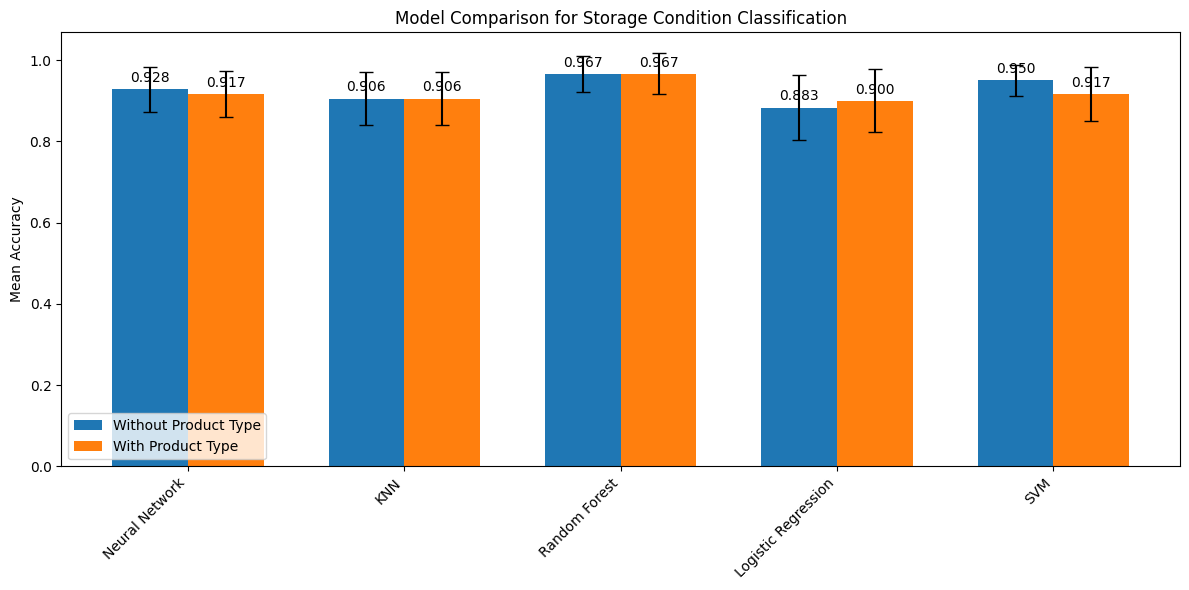


Classification Results Summary:

Neural Network:
Without Product Type: 0.9278 (±0.0558)
With Product Type: 0.9167 (±0.0569)

KNN:
Without Product Type: 0.9056 (±0.0660)
With Product Type: 0.9056 (±0.0660)

Random Forest:
Without Product Type: 0.9667 (±0.0444)
With Product Type: 0.9667 (±0.0509)

Logistic Regression:
Without Product Type: 0.8833 (±0.0803)
With Product Type: 0.9000 (±0.0778)

SVM:
Without Product Type: 0.9500 (±0.0389)
With Product Type: 0.9167 (±0.0669)


In [43]:
# Cell 6: Visualize Results
print("\nPreparing visualization...")
# Check which models were successful in both scenarios
models_without_product = set(results_without_product.keys())
models_with_product = set(results_with_product.keys())
common_models = list(models_without_product.intersection(models_with_product))

if common_models:
    # Create filtered results dictionary
    storage_results = {
        'Without Product Type': {model: results_without_product[model] 
                               for model in common_models},
        'With Product Type': {model: results_with_product[model] 
                            for model in common_models}
    }

    # Create visualization
    plot_model_comparison(
        storage_results,
        classification_type='storage',
        save_path='storage_condition_comparison.png'
    )
    
    # Print summary of results
    print("\nClassification Results Summary:")
    for model in common_models:
        print(f"\n{model}:")
        print(f"Without Product Type: {results_without_product[model]['mean_accuracy']:.4f} "
              f"(±{results_without_product[model]['std_accuracy']:.4f})")
        print(f"With Product Type: {results_with_product[model]['mean_accuracy']:.4f} "
              f"(±{results_with_product[model]['std_accuracy']:.4f})")
else:
    print("No models were successfully trained in both scenarios!")



In [44]:
# Cell 7: Save Results
print("\nSaving detailed results...")
def save_detailed_results(results, filename):
    """Save detailed results to file"""
    with open(filename, 'w') as f:
        for scenario, scenario_results in results.items():
            f.write(f"\n{scenario}\n")
            f.write("="*50 + "\n")
            
            for model, model_results in scenario_results.items():
                f.write(f"\n{model}\n")
                f.write("-"*30 + "\n")
                f.write(f"Best parameters: {model_results['best_params']}\n")
                f.write(f"Cross-validation accuracies: {model_results['fold_accuracies']}\n")
                f.write(f"Mean accuracy: {model_results['mean_accuracy']:.4f} "
                       f"(±{model_results['std_accuracy']:.4f})\n")
                f.write("\nClassification Report:\n")
                f.write(model_results['classification_report'])
                f.write("\n")

if common_models:
    save_detailed_results(storage_results, 'storage_condition_classification_results.txt')

print("\nAnalysis complete!")


Saving detailed results...

Analysis complete!
